# **1 - Imports**

In [16]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB4, ResNet152V2
from tensorflow.keras.layers import GlobalAvgPool2D, Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **2 - Data Distribution**

In [17]:
dataset_path = '../input/weather-dataset/dataset'
class_names = sorted(os.listdir(dataset_path))
class_count = len(class_names)
class_dist = [len(os.listdir(dataset_path + "/" + name)) for name in class_names]
print(class_count)
class_dist

11


[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

In [18]:
fig = px.pie(names=class_names, values=class_dist, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

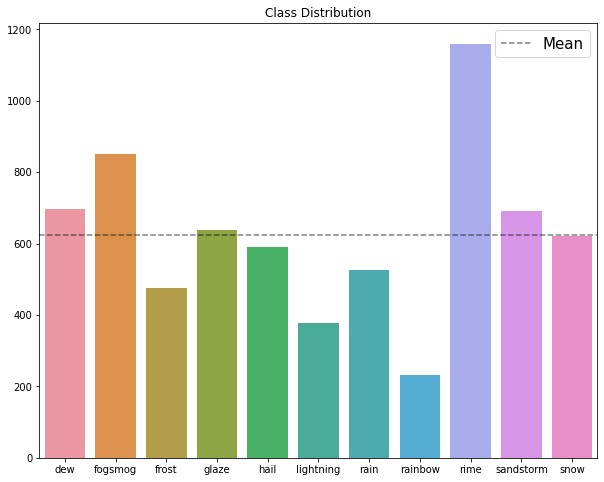

In [19]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dist
)
plt.axhline(np.mean(class_dist), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

## **3 - Data Preprocessing**

In [20]:
channels=3
batch_size=20
img_size=(256,256)
img_shape=(img_size[0], img_size[1], channels)

# Initialize DataGenerator
gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

# Load Data
train_gen = gen.flow_from_directory(dataset_path, target_size=img_size, class_mode="categorical", subset='training', shuffle=True, batch_size=batch_size)
valid_gen = gen.flow_from_directory(dataset_path, target_size=img_size, class_mode="categorical", subset='validation', shuffle=True, batch_size=batch_size)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [21]:
train_dict=train_gen.class_indices
classes=list(train_dict.keys()) 
train_dict

{'dew': 0,
 'fogsmog': 1,
 'frost': 2,
 'glaze': 3,
 'hail': 4,
 'lightning': 5,
 'rain': 6,
 'rainbow': 7,
 'rime': 8,
 'sandstorm': 9,
 'snow': 10}

## **4 - Data Visualisation**

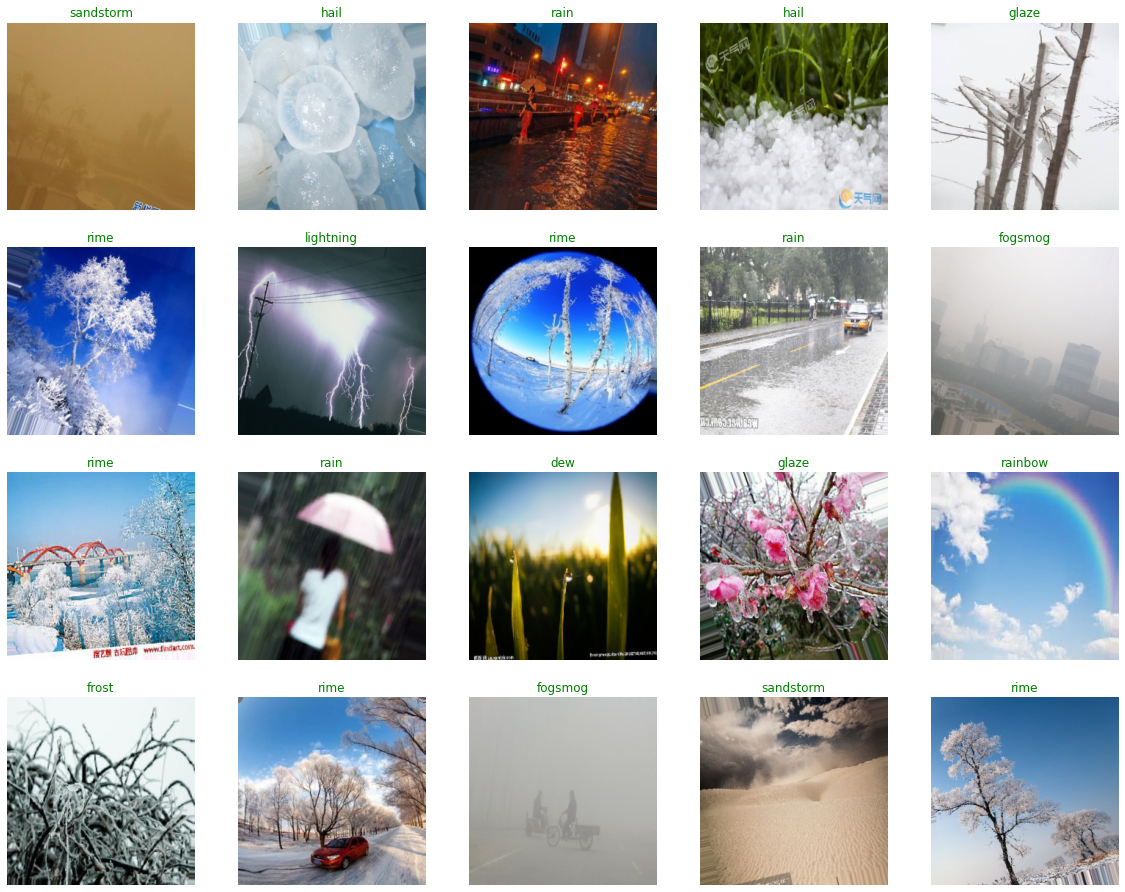

In [22]:
images,labels=next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name=classes[index]
    plt.title(class_name, color='green', fontsize=12)
    plt.axis('off')
plt.show()

## **5- ResNet152V2 Model**

In [58]:
resnet_base_model = ResNet152V2(include_top=False, input_shape=img_shape)
resnet_base_model.trainable = False

resnet_model = Sequential([
    resnet_base_model,
    GlobalAvgPool2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation="softmax")
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate = 5e-4),
    metrics=['accuracy']
)

In [59]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("resnet.h5", save_best_only=True)
]
resnet_model.fit(x=train_gen, epochs=20, callbacks=callbacks, validation_data=valid_gen)

Epoch 1/20
275/275 [==============================] - 153s 532ms/step - loss: 1.0166 - accuracy: 0.6656 - val_loss: 0.4701 - val_accuracy: 0.8408


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/20
275/275 [==============================] - 144s 523ms/step - loss: 0.5532 - accuracy: 0.8178 - val_loss: 0.4380 - val_accuracy: 0.8510
Epoch 3/20
275/275 [==============================] - 139s 506ms/step - loss: 0.4463 - accuracy: 0.8545 - val_loss: 0.4090 - val_accuracy: 0.8568
Epoch 4/20
275/275 [==============================] - 138s 502ms/step - loss: 0.3964 - accuracy: 0.8616 - val_loss: 0.3959 - val_accuracy: 0.8714
Epoch 5/20
275/275 [==============================] - 138s 502ms/step - loss: 0.3357 - accuracy: 0.8888 - val_loss: 0.4042 - val_accuracy: 0.8605
Epoch 6/20
275/275 [==============================] - 139s 506ms/step - loss: 0.3159 - accuracy: 0.8900 - val_loss: 0.4089 - val_accuracy: 0.8751
Epoch 7/20
275/275 [==============================] - 139s 506ms/step - loss: 0.2916 - accuracy: 0.9008 - val_loss: 0.4061 - val_accuracy: 0.8714
Epoch 8/20
275/275 [==============================] - 139s 505ms/step - loss: 0.2675 - accuracy: 0.9097 - val_loss: 0.4309 -

In [60]:
images,labels=next(valid_gen)
pred = resnet_model.predict(images)
p=[np.argmax(pred[i]) for i in range(pred.shape[0])]

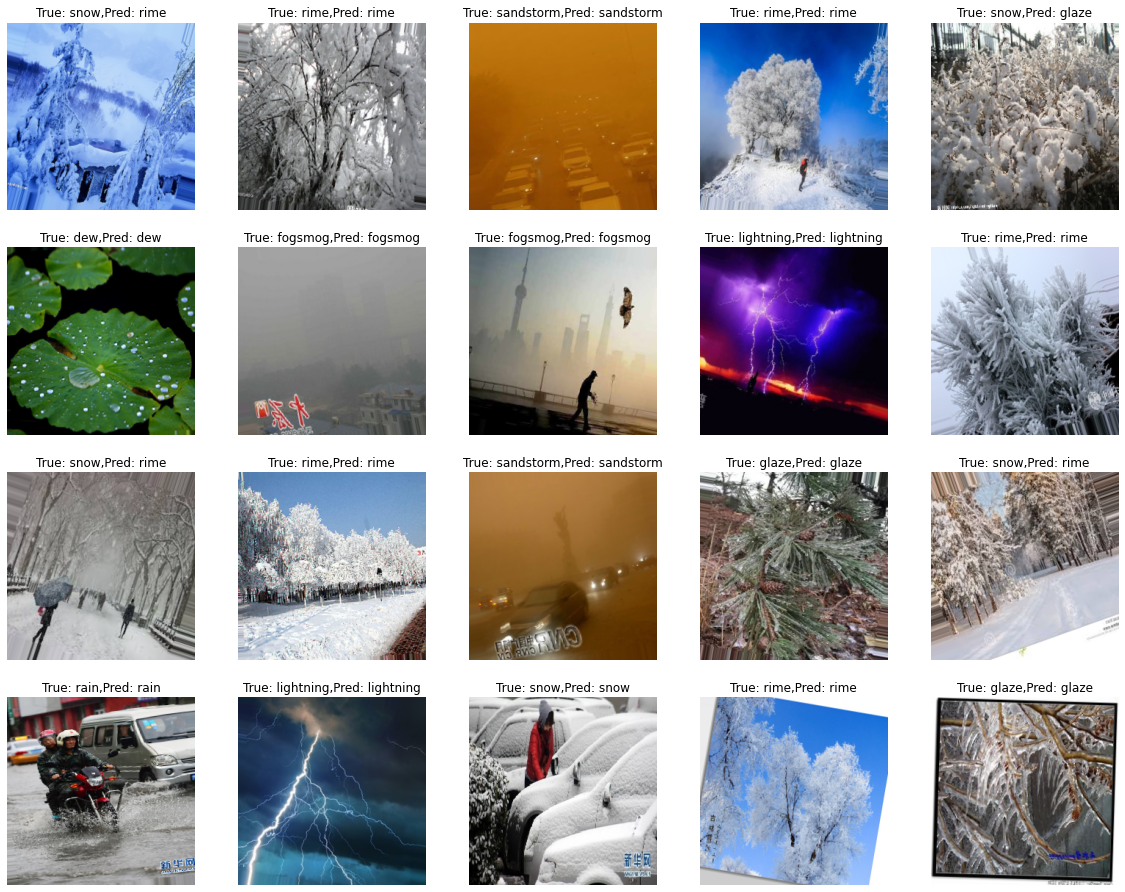

In [61]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    pred_label=class_names[p[i]]
    true_label=class_names[index]
    plt.title(f"True: {true_label},Pred: {pred_label}")
    plt.axis('off')
plt.show()